# Deep Convolutional GAN (DCGAN) with SVHN

In this notebook, I use The **Street View House Numbers (SVHN) Dataset** [[1]](#ref1) to train DCGAN.  

If you are not familiar with GAN (Generative Adversarial Network), please see [gan_mnist.ipynb](gan_mnist.ipynb) that explains the concept in details using a simple network.  This notebook is a follow-up on that, and uses more convolutional networks for the generator and the discriminator.

The code is based on **Deep Convolutional GANs by Udacity** [[2]](#ref2).  Udacity uses TensorFlow but I use Keras on TensorFlow.

In [1]:
import numpy as np
from scipy.io import loadmat
import keras
import keras.backend as K
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Loading SVHN Dataset

Download SVHN dataset from the Stanford website if not already done.

In [2]:
#
# Uncomment below to download SVHN datasets (it takes some time - a good time for a cup of coffee or two)
#
#!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
#!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

The data is in MATLAB format.  We use scipy's `loadmat` to load the data in numpy array.

In [3]:
train_data = loadmat('train_32x32.mat')
test_data  = loadmat('test_32x32.mat')

The `train_data` and `test_data` are `dict` object.  

They are the real images of house numbers but the shape is in (image_height, image_width, channels, records).

In [4]:
X_train, y_train = train_data['X'], train_data['y']
X_test,  y_test  = test_data['X'],  test_data['y']

X_train.shape

(32, 32, 3, 73257)

We roll the axis backward to make the shape to (records, image_height, image_width, channels).

In [5]:
# roll axis backward

X_train = np.rollaxis(X_train, 3)
X_test  = np.rollaxis(X_test, 3)

X_train.shape

(73257, 32, 32, 3)

Let's examine some sample images.

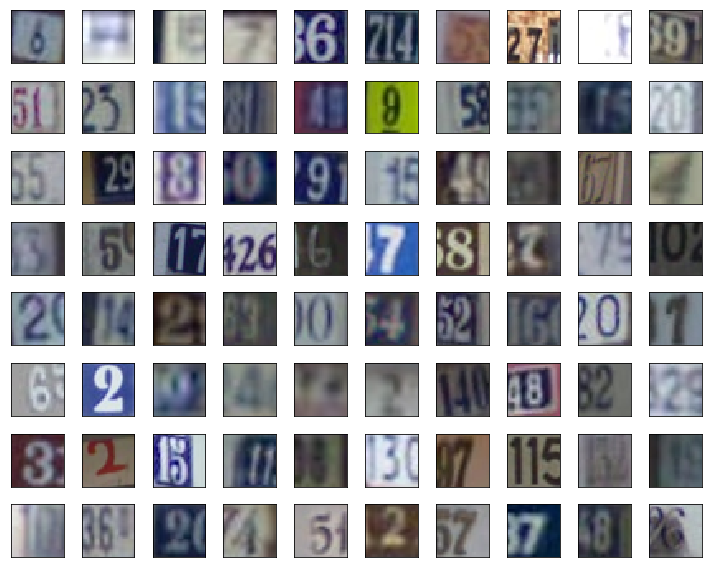

In [6]:
sample_images = X_train[np.random.choice(len(X_train), size=80, replace=False)]

plt.figure(figsize=(10, 8))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(sample_images[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Preprocessing and Deprocessing

As usual, we need preprocessing and later deprocessing of the images.  

As we will see later on, the generator is using `tanh` activation, for which we need to preprocess the image data into the range between -1 and 1.

In [7]:
def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255) # make sure to use uint8 type otherwise the image won't display properly

Apply the preprocessing on the train and test images (and they are the real images as oppose to the generated images).

In [8]:
X_train_real = preprocess(X_train)
X_test_real  = preprocess(X_test)

## Generator

The generator takes a latent sample (100 randomly generated numbers) and produces a 32x32 color image that should look like one from the SVHN dataset.

The original paper [[3]](#ref3) proposes the following generator network architecture.

<img src='../images/dcgan_svhn/generator.png' width='70%'>

Although the size of the images usedin the original paper is 64x64, the size of the images in SVHN is 32x32.  As such, I used smaller networks.

The generator takes a latent sample which has 100 random numbers.  It uses the fully connected layer to expand the dimension to $4 \times 4 \times 256$ neurons so that it can be reshaped into 4x4 2D shape with 512 filters.

After that, each layer's height and width are doubled by the transpose convolution and the filters are halved.  The last layer produces a 32x32 2D image with 3 channels.

The activation of the output layer is `tanh` which the discriminator expects.

In [9]:
def make_generator(input_size, leaky_alpha):
    # generates images in (32,32,3)
    return Sequential([
        Dense(4*4*512, input_shape=(input_size,)),
        Reshape(target_shape=(4, 4, 512)),                              # 4,4,512
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'), # 8,8,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'), # 16,16,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'),   # 32,32,3
        Activation('tanh')
    ])

## Discriminator


The discriminator is a classifier to tell if the input image is real or fake.  

It is a convolutional neural network that takes a 32x32 image with 3 channels.  The values in the image is expected to be between -1 and 1.

The activation of the output layer is `sigmoid` and the discriminator outputs a probability of the image being real.

In [10]:
def make_discriminator(leaky_alpha):
    # classifies images in (32,32,3)
    return Sequential([        
        Conv2D(64, kernel_size=5, strides=2, padding='same',     # 16,16,64
               input_shape=(32,32,3)),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(128, kernel_size=5, strides=2, padding='same'),   # 8,8,128
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Conv2D(256, kernel_size=5, strides=2, padding='same'),   # 4,4,256
        BatchNormalization(),
        LeakyReLU(alpha=leaky_alpha),
        Flatten(),
        Dense(1),
        Activation('sigmoid')        
    ])

## DCGAN

We connect the generator and the discriminator to make a DCGAN.

The input to the DCGAN is a latent sample.  The generator inside DCGAN produces an image which is fed into the discriminator inside the DCGAN.  So, the output of DCGAN is the probability of the generated image being real.

In [11]:
# beta_1 is the exponential decay rate for the 1st moment estimates in Adam optimizer
def make_DCGAN(sample_size, 
               g_learning_rate, 
               g_beta_1,
               d_learning_rate,
               d_beta_1,
               leaky_alpha):
    # clear any session data
    K.clear_session()
    
    # generator
    generator = make_generator(sample_size, leaky_alpha)

    # discriminator
    discriminator = make_discriminator(leaky_alpha)
    discriminator.compile(optimizer=Adam(lr=d_learning_rate, beta_1=d_beta_1), loss='binary_crossentropy')
    
    # GAN
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    
    return gan, generator, discriminator

## Training DCGAN

The below is a function to generate latent samples.

In [12]:
def make_latent_samples(n_samples, sample_size):
    #return np.random.uniform(-1, 1, size=(n_samples, sample_size))
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

The below is a function to set the discriminator to trainable or non-trainable.

In [13]:
def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable

The below is a function to create a batch of labels.

In [14]:
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

This is to show a epoch - loss chart.

In [15]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

This is to show generated images.

In [16]:
def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

The training DCGAN is essentially the same as training a simple GAN in [gan_mnist.ipynb](gan_mnist.ipynb).

* set the discriminator trainable
* train the discriminator with real images with the label smoothing   (labels=1-smooth)
* train the discriminator with fake images generated by the generator (labels=0)
* set the discriminator non-trainable
* train the DCGAN with generated images (labels=1)

We repeat this process many times until the discriminator loss and the generator loss stabilizes.

In [17]:
def train(
    g_learning_rate, # learning rate for the generator
    g_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    d_learning_rate, # learning rate for the discriminator
    d_beta_1,        # the exponential decay rate for the 1st moment estimates in Adam optimizer
    leaky_alpha,
    smooth=0.1,
    sample_size=100, # latent sample size (i.e. 100 random numbers)
    epochs=25,
    batch_size= 128, # train batch size
    eval_size=16,    # evaluate size
    show_details=True):
    
    # labels for the batch size and the test size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    # create a GAN, a generator and a discriminator
    gan, generator, discriminator = make_DCGAN(
        sample_size, 
        g_learning_rate, 
        g_beta_1,
        d_learning_rate,
        d_beta_1,
        leaky_alpha)

    losses = []
    for e in range(epochs):
        for i in range(len(X_train_real)//batch_size):
            # real SVHN digit images
            X_batch_real = X_train_real[i*batch_size:(i+1)*batch_size]

            # latent samples and the generated digit images
            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)

            # train the discriminator to detect real and fake images
            make_trainable(discriminator, True)
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)

            # train the generator via GAN
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)

        # evaluate
        X_eval_real = X_test_real[np.random.choice(len(X_test_real), eval_size, replace=False)]

        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)

        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real) # we want the fake to be realistic!

        losses.append((d_loss, g_loss))

        print("Epoch: {:>3}/{} Discriminator Loss: {:>7.4f}  Generator Loss: {:>7.4f}".format(
            e+1, epochs, d_loss, g_loss))

        # show the generated images
        if (e+1) % 5 == 0:
            show_images(X_eval_fake[:10])
    
    if show_details:
        show_losses(losses)
        show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

### Training 1

Although, the generator and the discriminator in this project are not exactly the same as in the DCGAN paper [[3]](#ref3), I tried the following hyterparameters as per the paper (the quotes are from the paper):

* batch_size = 128

> All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128. 

* use the Adam optimizer with beta_1 tuned (see below)

> While previous GAN work has used momentum to accelerate training, we used the Adam optimizer (Kingma & Ba, 2014) with tuned hyperparameters.

* alpha=0.2 in LeakyReLU

> In the LeakyReLU, the slope of the leak was set to 0.2 in all models.

* 0.0002 for the learning rate

> We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. 

* 0.5 for `beta_1` 

> we found leaving the momentum term β1 at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

Note: `beta_1` is the exponential decay rate for the momentum term (an exponential average of weight gradients).  The momentum is the estimation of true gradients.  It is used to realize smoother weight updates by avoiding random spikes.

Epoch:   1/25 Discriminator Loss:  1.0658  Generator Loss: 16.1181
Epoch:   2/25 Discriminator Loss:  0.9079  Generator Loss: 16.1181
Epoch:   3/25 Discriminator Loss:  0.5242  Generator Loss: 16.0489
Epoch:   4/25 Discriminator Loss:  0.2788  Generator Loss: 12.3695
Epoch:   5/25 Discriminator Loss:  0.2002  Generator Loss:  9.1594


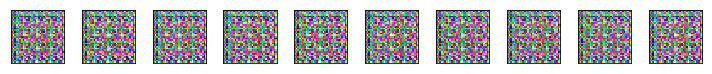

Epoch:   6/25 Discriminator Loss:  0.1439  Generator Loss:  6.6416
Epoch:   7/25 Discriminator Loss:  2.5328  Generator Loss:  0.1687
Epoch:   8/25 Discriminator Loss:  1.6444  Generator Loss:  0.4052
Epoch:   9/25 Discriminator Loss:  2.4068  Generator Loss:  0.2454
Epoch:  10/25 Discriminator Loss:  1.2797  Generator Loss:  0.6608


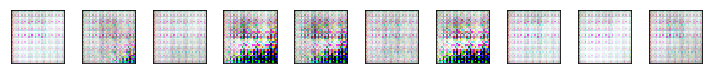

Epoch:  11/25 Discriminator Loss:  2.9178  Generator Loss:  0.4874
Epoch:  12/25 Discriminator Loss:  0.9137  Generator Loss:  1.5469
Epoch:  13/25 Discriminator Loss:  0.2800  Generator Loss: 16.1181
Epoch:  14/25 Discriminator Loss:  0.3562  Generator Loss: 15.6062
Epoch:  15/25 Discriminator Loss:  0.3022  Generator Loss: 14.3462


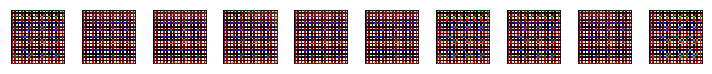

Epoch:  16/25 Discriminator Loss:  0.9633  Generator Loss:  1.2981
Epoch:  17/25 Discriminator Loss:  1.0367  Generator Loss:  1.6721
Epoch:  18/25 Discriminator Loss:  4.8259  Generator Loss:  7.8599
Epoch:  19/25 Discriminator Loss:  4.3901  Generator Loss:  6.9550
Epoch:  20/25 Discriminator Loss:  3.5891  Generator Loss:  5.9843


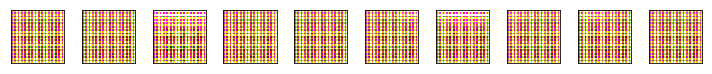

Epoch:  21/25 Discriminator Loss:  3.2345  Generator Loss:  5.3873
Epoch:  22/25 Discriminator Loss:  2.1890  Generator Loss:  4.2999
Epoch:  23/25 Discriminator Loss:  1.8481  Generator Loss:  2.9621
Epoch:  24/25 Discriminator Loss:  1.1759  Generator Loss:  2.3125
Epoch:  25/25 Discriminator Loss:  0.8052  Generator Loss:  1.6752


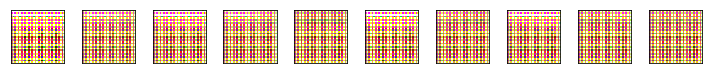

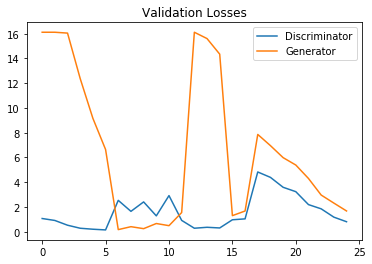

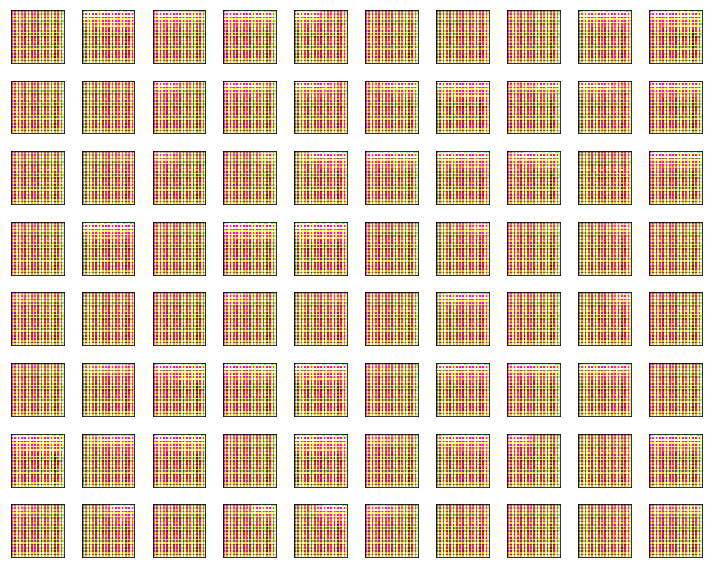

In [18]:
train(g_learning_rate=0.0002, g_beta_1=0.5, d_learning_rate=0.0002, d_beta_1=0.5, leaky_alpha=0.2);

### Training 1 Observations

* it produced garbage images oly.  
* the generator loss is oscillating.
* the discriminator loss is relatively stable.  

### Training 2

Let's reduce the generator learning rate and increase the discriminator's learning rate to see how it goes.

Epoch:   1/25 Discriminator Loss:  0.5118  Generator Loss: 16.1181
Epoch:   2/25 Discriminator Loss:  2.0635  Generator Loss:  1.1074
Epoch:   3/25 Discriminator Loss:  1.1512  Generator Loss:  1.3255
Epoch:   4/25 Discriminator Loss:  1.2523  Generator Loss:  1.4457
Epoch:   5/25 Discriminator Loss:  1.3070  Generator Loss:  1.4936


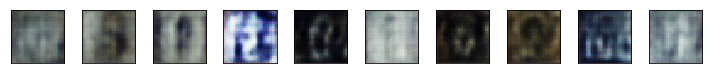

Epoch:   6/25 Discriminator Loss:  1.4173  Generator Loss:  0.5979
Epoch:   7/25 Discriminator Loss:  1.5834  Generator Loss:  1.8457
Epoch:   8/25 Discriminator Loss:  1.4728  Generator Loss:  1.0308
Epoch:   9/25 Discriminator Loss:  1.0157  Generator Loss:  1.4005
Epoch:  10/25 Discriminator Loss:  0.8864  Generator Loss:  1.7082


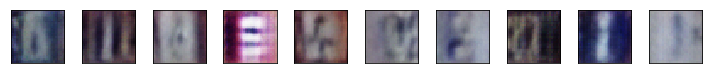

Epoch:  11/25 Discriminator Loss:  1.4113  Generator Loss:  1.7030
Epoch:  12/25 Discriminator Loss:  1.3642  Generator Loss:  1.7837
Epoch:  13/25 Discriminator Loss:  1.5370  Generator Loss:  1.9959
Epoch:  14/25 Discriminator Loss:  1.1734  Generator Loss:  1.8924
Epoch:  15/25 Discriminator Loss:  1.5878  Generator Loss:  1.6711


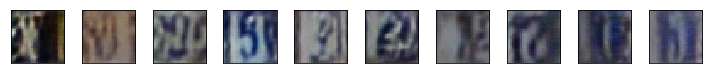

Epoch:  16/25 Discriminator Loss:  1.3258  Generator Loss:  1.8857
Epoch:  17/25 Discriminator Loss:  1.6205  Generator Loss:  1.8108
Epoch:  18/25 Discriminator Loss:  1.5971  Generator Loss:  2.1411
Epoch:  19/25 Discriminator Loss:  1.5212  Generator Loss:  2.6963
Epoch:  20/25 Discriminator Loss:  1.7137  Generator Loss:  2.3894


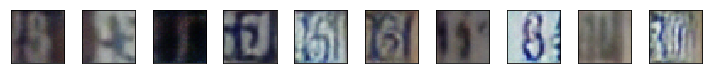

Epoch:  21/25 Discriminator Loss:  1.8297  Generator Loss:  2.4010
Epoch:  22/25 Discriminator Loss:  1.5695  Generator Loss:  2.2581
Epoch:  23/25 Discriminator Loss:  1.7912  Generator Loss:  2.9209
Epoch:  24/25 Discriminator Loss:  1.3153  Generator Loss:  2.0092
Epoch:  25/25 Discriminator Loss:  1.6001  Generator Loss:  2.4412


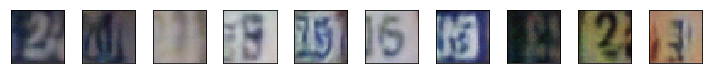

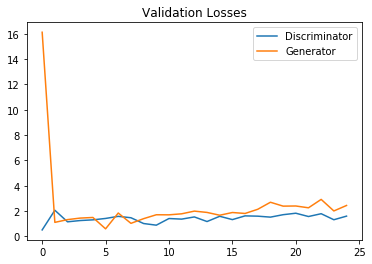

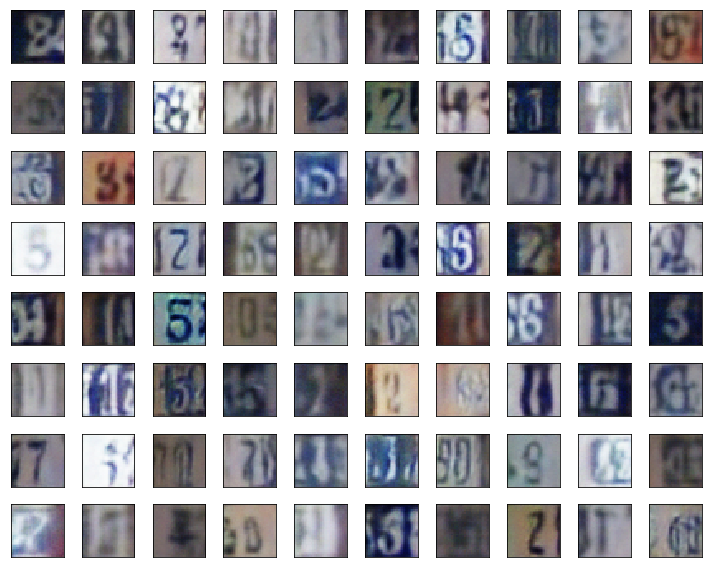

In [19]:
train(g_learning_rate=0.0001, g_beta_1=0.5, d_learning_rate=0.001, d_beta_1=0.5, leaky_alpha=0.2);

### Training 2 Observations

* It does generate house numbers.  Much better than the training 1.
* The generator loss and the discriminator loss are more stable.

### Training 3

The training 2 is much better than the training 1.  What else can I try?  How about setting the beta_1 to the default value of 0.9?

Epoch:   1/25 Discriminator Loss:  3.1117  Generator Loss:  1.7243
Epoch:   2/25 Discriminator Loss:  1.4627  Generator Loss:  0.6622
Epoch:   3/25 Discriminator Loss:  1.8335  Generator Loss:  4.8597
Epoch:   4/25 Discriminator Loss:  2.3240  Generator Loss:  1.7151
Epoch:   5/25 Discriminator Loss:  0.8671  Generator Loss:  3.9423


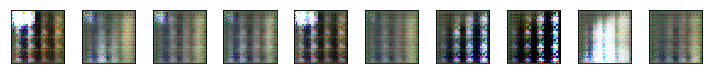

Epoch:   6/25 Discriminator Loss:  1.1062  Generator Loss:  0.8171
Epoch:   7/25 Discriminator Loss:  0.7889  Generator Loss:  1.7749
Epoch:   8/25 Discriminator Loss:  0.9905  Generator Loss:  3.5142
Epoch:   9/25 Discriminator Loss:  0.8908  Generator Loss:  2.2767
Epoch:  10/25 Discriminator Loss:  0.9714  Generator Loss:  2.4390


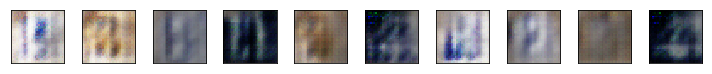

Epoch:  11/25 Discriminator Loss:  0.9164  Generator Loss:  1.4530
Epoch:  12/25 Discriminator Loss:  1.1058  Generator Loss:  2.6967
Epoch:  13/25 Discriminator Loss:  0.8665  Generator Loss:  2.0809
Epoch:  14/25 Discriminator Loss:  1.3502  Generator Loss:  2.3084
Epoch:  15/25 Discriminator Loss:  0.6678  Generator Loss:  1.9935


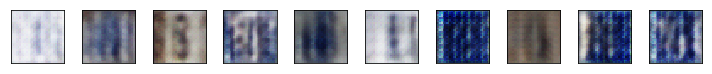

Epoch:  16/25 Discriminator Loss:  0.8483  Generator Loss:  2.1788
Epoch:  17/25 Discriminator Loss:  0.9111  Generator Loss:  2.3969
Epoch:  18/25 Discriminator Loss:  0.7741  Generator Loss:  1.8788
Epoch:  19/25 Discriminator Loss:  0.9398  Generator Loss:  1.7935
Epoch:  20/25 Discriminator Loss:  1.1998  Generator Loss:  2.4455


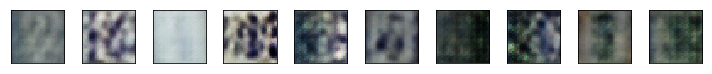

Epoch:  21/25 Discriminator Loss:  1.1707  Generator Loss:  2.9551
Epoch:  22/25 Discriminator Loss:  0.8431  Generator Loss:  2.1464
Epoch:  23/25 Discriminator Loss:  1.2520  Generator Loss:  2.4153
Epoch:  24/25 Discriminator Loss:  1.1955  Generator Loss:  1.9726
Epoch:  25/25 Discriminator Loss:  1.1558  Generator Loss:  2.0735


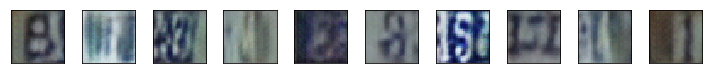

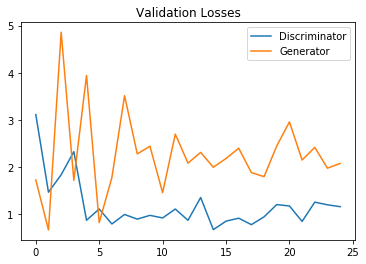

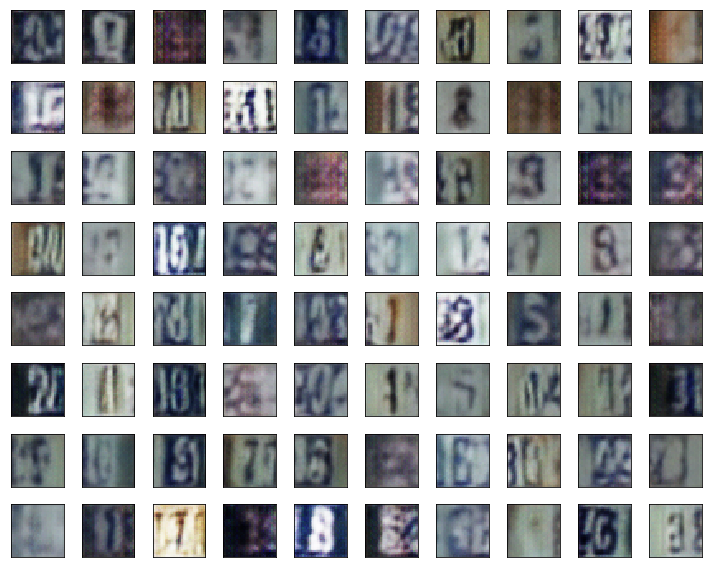

In [20]:
train(g_learning_rate=0.0001, g_beta_1=0.9, d_learning_rate=0.001, d_beta_1=0.9, leaky_alpha=0.2);

### Training 3 Observations

* The generated images look worse than the training 2
* The generator loss goes up and down.
* The discriminator loss goes down and stays lower.

## Conclusion

* GANs in general is notoriously hard to train. This project is also not easy in that aspect.
* Overall, the training 2 performed the best in terms of realness of the generated images.
* More hyperparameter tuning should be experimented if we want to improve further.

## References

<a id="ref1"></a>
### [1] The Street View House Numbers (SVHN) Dataset

Stanford

http://ufldl.stanford.edu/housenumbers/

<a id="ref2"></a>
### [2] Deep Convolutional GANs

Udacity

https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb

<a id="ref3"></a>
### [3] Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

Alec Radford & Luke Metz (indico Research), Soumith Chintala (Facebook AI Research)

https://arxiv.org/pdf/1511.06434.pdf

<a id="ref4"></a>
### [4] ADAM: A Method for Stocastic Optimization

Diederik P. Kingma (University of Amsterdam, OpenAI), Jimmy Lei Ba (University of Toronto)

https://arxiv.org/pdf/1412.6980.pdf